In [1]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as appl
from sklearn.model_selection import train_test_split
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from keras import callbacks  
from keras.models import load_model
from keras.utils import np_utils

In [2]:
load_path='E:/VA/onehandtwohand/128/106words_DSLR_FH/'

In [3]:
CATEGORIES=np.load(load_path+'cat_106.npy', allow_pickle=True)

In [4]:
IMG_SIZE=128

In [5]:
cat_len=len(CATEGORIES)
print(cat_len)

106


# Save combined data npy

In [1]:
# model

# model_name1 = 'InceptionResNetV2'
# model_name1 = '4layer'
model_name1 = 'Xception_lr0.00001_106words_dslr128-99.69'
#model_name2 = 'VGG16'
# model_name1 = 'DenseNet121'
# model_name1 = 'InceptionV3'

Loading

In [7]:
X=np.load(load_path+'X_dslr.npy', allow_pickle=True)
Y=np.load(load_path+'Y_dslr.npy', allow_pickle=True)

In [8]:
X = X.astype('float32')
X /= 255


In [9]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")

Splitting
pass


In [10]:
del X,Y

In [11]:
print('Image Data Augmentation')
from keras.preprocessing.image import ImageDataGenerator
val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2)
#                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
val_generator.fit(X_train)
val_generator.fit(X_new)
val_generator.fit(X_test)

print("done")

Image Data Augmentation
done


In [13]:
# case 1: pretrained without weight ............... retraining architechture

model_name = 'Xception'


exec('from tensorflow.keras.applications import '+ model_name)


## case 1:
exec('MODEL = '+model_name+'(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=True, weights=None, classes = cat_len)')
for layers in MODEL.layers: 
    layers.trainable=True
    
model1=MODEL
model1.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [14]:
print('Training model 1')
opt = Adam(learning_rate=0.00001)
earlystopping = callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
model1.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
# model1.summary()



history_const = model1.fit(X_train, y_train,batch_size=50, epochs = 1000, validation_data=(X_test,y_test),
                   callbacks= [earlystopping])


Training model 1
Epoch 1/1000
487/487 [==============================] - 63s 109ms/step - loss: 3.7314 - accuracy: 0.2713 - val_loss: 4.6753 - val_accuracy: 0.0141
Epoch 2/1000
487/487 [==============================] - 52s 106ms/step - loss: 1.7711 - accuracy: 0.6485 - val_loss: 1.3053 - val_accuracy: 0.7323
Epoch 3/1000
487/487 [==============================] - 51s 105ms/step - loss: 0.6426 - accuracy: 0.9030 - val_loss: 0.3689 - val_accuracy: 0.9472
Epoch 4/1000
487/487 [==============================] - 51s 105ms/step - loss: 0.2184 - accuracy: 0.9793 - val_loss: 0.1646 - val_accuracy: 0.9762
Epoch 5/1000
487/487 [==============================] - 51s 105ms/step - loss: 0.0854 - accuracy: 0.9959 - val_loss: 0.1011 - val_accuracy: 0.9857
Epoch 6/1000
487/487 [==============================] - 51s 104ms/step - loss: 0.0389 - accuracy: 0.9996 - val_loss: 0.0638 - val_accuracy: 0.9920
Epoch 7/1000
487/487 [==============================] - 51s 105ms/step - loss: 0.0208 - accuracy: 1.0

In [ ]:
print('Saving')
np.save(load_path+model_name1+'_history.npy',history_const.history)
model1.save(load_path+model_name1+'_model.h5') 
print("saved")

Saving


In [ ]:
# # #load saved history
# history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()

# # #load saved model
# model1=load_model(load_path+model_name1+'_model.h5')

# print("loaded")

Plots


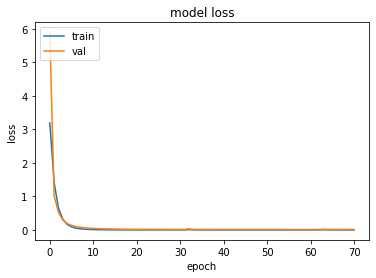

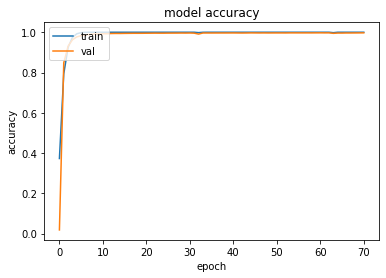

In [17]:
print('Plots')
plt.plot(history_const.history['loss'])
plt.plot(history_const.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('F:/VA/onehandtwohand/26words_DSLR_results/'+model_name1+'_loss.png')
plt.savefig(load_path+model_name1+'_loss.png')
plt.show()
plt.plot(history_const.history['accuracy'])
plt.plot(history_const.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(load_path+model_name1+'_accuracy.png')
plt.show()

In [ ]:
print('Confusion matrix')
Y_pred = model1.predict(X_new)
y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new, axis=1)

cm=metrics.confusion_matrix(y_test1, y_pred)


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (200, 100)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig(load_path+model_name1+'_cm.png',bbox_inches='tight')
plt.show()


In [ ]:
#PLot fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(np.arange(cat_len), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(cat_len), CATEGORIES)
plt.savefig(load_path+model_name1+'_incorrect_percentage.png',bbox_inches='tight')
plt.show()

In [ ]:
#CHECK RANDOM IMAGES FROM TESTED DATA WHETHER RIGHT OR WRONG

i = random.randint(1,cat_len)
plt.imshow(X_new[i,:,:,2]) 
print("Predicted Label: ", CATEGORIES[int(y_pred[i])])
print("True Label: ", CATEGORIES[int(y_test1[i])])

# Colourful mediapipe testing with VA_create_3.0

In [18]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
    
def draw_landmarks(image, results):   
    #face
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
#     #pose
#     mp_drawing.draw_landmarks(
#         image,
#         results.pose_landmarks,
#         mp_holistic.POSE_CONNECTIONS,
#         landmark_drawing_spec=mp_drawing_styles
#         .get_default_pose_landmarks_style())
    
    #left hand
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
#         landmark_drawing_spec=None,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # right hand
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
#         landmark_drawing_spec=None,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

In [19]:
## For veryyyyyyyy beautiful webcam input:

cap = cv2.VideoCapture(0)
org = (20, 20)  
org1 = (310, 20) 
fontScale = 0.65  
font = cv2.FONT_HERSHEY_SIMPLEX
# Blue color in BGR
color = (130, 0, 0)  
# Line thickness of 2 px
thickness = 1 
thickness1 = -1
start_point = (0,0)
end_point = (480,30)
color1 = (255, 255, 255)  

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
      while cap.isOpened():
        #image from feeder
        r, img_array = cap.read()
        img_array = cv2.flip(img_array, 1)
        img_array = img_array[:, 80:560, :]
        image, results = mediapipe_detection(img_array, holistic)
        draw_landmarks(image, results)
        if not (results.left_hand_landmarks or results.right_hand_landmarks):
            continue

        # white background
        img = np.zeros([480,480,3],dtype=np.uint8)
        img.fill(255) 
        draw_landmarks(img, results)

        # for prediction
        IMG_SIZE=128
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        X = X.astype('float32')
        X /= 255
        X = np.array(X)
        Y = model1.predict(X,verbose=1)

        if np.max(Y)>0.2:
            # for display
            image = cv2.rectangle(image, start_point, end_point, color1, thickness1)
            image = cv2.rectangle(image, (0,30), (480,30), color, 2)
            image = cv2.putText(image,"Prediction: "+ CATEGORIES[np.argmax(Y)], org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            image = cv2.putText(image,"Accuracy: "+ "%.2f" % np.max(Y), org1, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            #if np.max(Y)>0.95:
                #cv2.imwrite(load_path+'/test_images/'+CATEGORIES[np.argmax(Y)]+str(np.max(Y))+'.jpg',image)


        cv2.imshow('Realtime testing', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
                break
# close the camera
cap.release()

# close all the opened windows
cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 32ms/step
